In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler


sns.set(style='white', context='notebook', palette='deep')

Init Plugin
Init Graph Optimizer
Init Kernel


## 2 Data preparation

### 2.1 Load the Data

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

/Users/pablodigiusto/miniforge3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

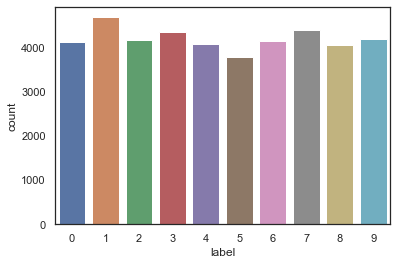

In [3]:
# Train data labels
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

# Check how many values for each number
g = sns.countplot(Y_train)
Y_train.value_counts()

### 2.2 Checking the data for null values

In [4]:
# Check the train data for null values
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
# Same as before for the test dataset
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

There are no missing or null values in any of the two datasets

### 2.3 Normalization of the data

In [6]:
# Grayscale normalization to reduce the effect of illumination's differences
X_train = X_train / 255.0
test = test / 255.0

### 2.4 Reshape

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

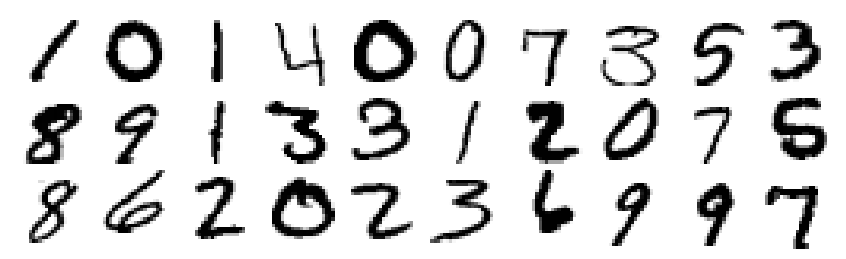

In [8]:
# Preview of the images
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

### 2.5 Label encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

### 2.6 Image Generator

by randomly rotating, scaling, and shifting Kaggle's 42,000 images we can generate much more data to train the model

In [10]:
# data augmentation
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

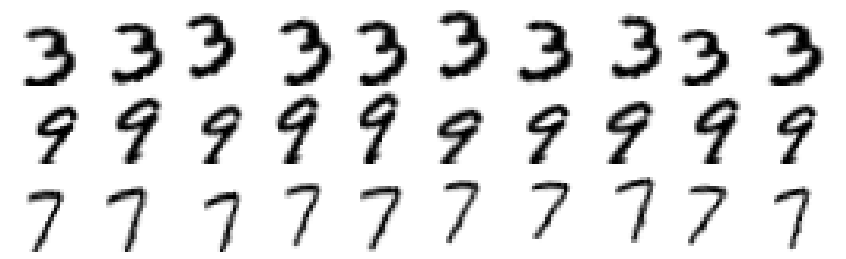

In [11]:
# preview of the augmented images
X_train3 = X_train[9,].reshape((1,28,28,1))
Y_train3 = Y_train[9,].reshape((1,10))
plt.figure(figsize=(15,4.5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    X_train2, Y_train2 = datagen.flow(X_train3,Y_train3).next()
    plt.imshow(X_train2[0].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
    if i==9: X_train3 = X_train[11,].reshape((1,28,28,1))
    if i==19: X_train3 = X_train[18,].reshape((1,28,28,1))
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

# 3 CNN

### 3.1 Build the model

We build 15 CNN using the architecture described above

In [12]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Metal device set to: Apple M1


2022-04-20 15:15:16.639405: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-20 15:15:16.639532: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 3.2 Train each one of the CNNs built

In [ ]:
# set the annealer to decrease learning rate each epoch
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

# TRAIN NETWORKS!
history = [0] * nets
epochs = 45
start_total = time.time()
for j in range(nets):
    start = time.time()
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))
    print("total time taken for this CNN: ", (time.time() - start)/60, "min")
print("total time taken to train all CNNs: ", (time.time() - start_total)/60, "min")

2022-04-20 15:15:18.016589: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-20 15:15:18.016757: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-20 15:15:18.359355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-20 15:15:37.968331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CNN 1: Epochs=45, Train accuracy=0.99648, Validation accuracy=0.99667
total time taken for this CNN:  15.547777851422628 min


2022-04-20 15:30:51.242380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-20 15:31:12.093448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


CNN 2: Epochs=45, Train accuracy=0.99640, Validation accuracy=0.99667
total time taken for this CNN:  14.85847133398056 min


2022-04-20 15:45:42.710544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-20 15:46:01.506814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


### 3.3 Ensemble predictions and submit

In [ ]:
# predict results with each one of the models
results = np.zeros( (test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test)
# select the indix with the maximum probability
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("MNIST-CNN-ENSEMBLE.csv",index=False)